# Linear Method Final

First we load the data set and remove the SWEETORSOUR predictor which is not useful and transform the catergorical variables into numerical ones. We also remove predictors with null variance.

In [1]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))] #to remove the SWEETORSOUR response variable
data$Intensity<-as.numeric(as.factor(data$Intensity)) #more efficient, this way we only have one column with 2=high, 1=low
data<-data[ , which(apply(data, 2, var) != 0)] #remove all columns with variance=0 (1842 columns)


We can then separate the data set into a training and validation set (here called test set) and separate them into predictors and prediction as well as dataframe and matrix (for computational purposes).

In [2]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

#data.train
data.train.y<-data.train$VALENCE.PLEASANTNESS
data.train.x<-data.train[,-(which(names(data.train) %in% c("VALENCE.PLEASANTNESS")))]
data.train.x.matrix<- as.matrix(data.train.x) #useful for some methods

#data.test
data.test.x<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x.matrix<- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y<-data.test$VALENCE.PLEASANTNESS

As a baseline model and to see the result of the simplest model, we perform a simple linear regression on the data set, taking into account all the predictors and no regularizers.

In [8]:
#Linear regression on the data set with the test and training errors

set.seed(199)
lm.fit <- lm(VALENCE.PLEASANTNESS ~ ., data.train)
RSS = sum((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2)
print(paste0("RSS on test set: ",RSS))
RMSE=sqrt(mean((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2))
print(paste0("RMSE on the test set:",RMSE))
summary(lm.fit)

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] "RSS on test set: 1392538778191.36"


Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] "RMSE on the test set:62719.4177438095"



Call:
lm(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.022  -1.907   0.000   1.522  46.652 

Coefficients: (2776 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)  
(Intercept)             1.119e+08  6.241e+07   1.793   0.0760 .
Intensity               2.044e+00  2.907e+00   0.703   0.4835  
complexity.from.pubmed -8.953e+01  4.345e+01  -2.061   0.0419 *
MW                     -2.843e+04  1.665e+04  -1.707   0.0908 .
AMW                    -4.267e+05  2.333e+05  -1.829   0.0703 .
Sv                      7.638e+06  4.219e+06   1.810   0.0732 .
Se                      7.733e+06  4.225e+06   1.831   0.0701 .
Sp                     -1.929e+06  1.056e+06  -1.827   0.0707 .
Si                      3.347e+06  1.865e+06   1.795   0.0756 .
Mv                      1.060e+07  5.811e+06   1.824   0.0712 .
Me                      3.446e+05  1.509e+05   2.284   0.0245 *
Mp            

As we can see, the test error obtained is extremely high and the linear fit is not a suitable approach. Linear fit is not really recommended when the number of predictors exceed the number of sample (which is clearly our case) and this generates warning. We will thus use more regularized approaches.A possible method is lasso regularization where the parameters are constrained. To choose the best lambda parameter (that is the strength of the regularization) we perform cross-validation on the different lambdas and choose the one with the best performances for our model.

Loading required package: Matrix
Loaded glmnet 4.0-2


[1] "RMSE on the training set: 19.3001854063458"
[1] "RMSE on the test set: 22.5701209247349"


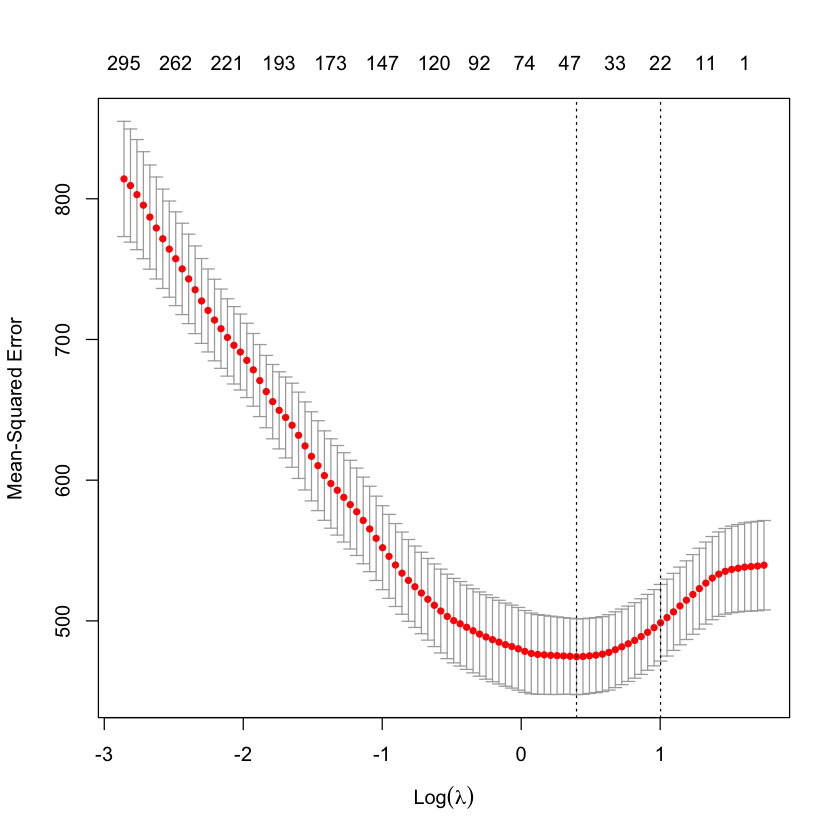

In [4]:
#Cross-validation Lasso 
set.seed(12)
#install.packages('glmnet')
library(glmnet)

#cross-validation lasso on training set
cv.lasso <- cv.glmnet(data.train.x.matrix, data.train.y, alpha = 1)
plot(cv.lasso)

best.lasso <- glmnet(data.train.x.matrix, data.train.y, alpha = 1, lambda = cv.lasso$lambda.min)#pick the best lambda determined by cross-validation
coeffs<-coef(best.lasso)

#predict the training data
y<-predict(best.lasso,data.train.x.matrix)
RMSE.train=sqrt(mean((y-data.train.y)**2))
print(paste0("RMSE on the training set: ",RMSE.train))

#predict the validation data
y<-predict(best.lasso, data.test.x.matrix)
RMSE.test=sqrt(mean((y-data.test.y)**2))
print(paste0("RMSE on the test set: ", RMSE.test))

And similary using Ridge regression where the square of the parameters are constrained and with the same method to choose the optimal lambda.


[1] "RMSE for training set: 18.7726252859476"
[1] "RMSE for test set: 22.5009722975498"


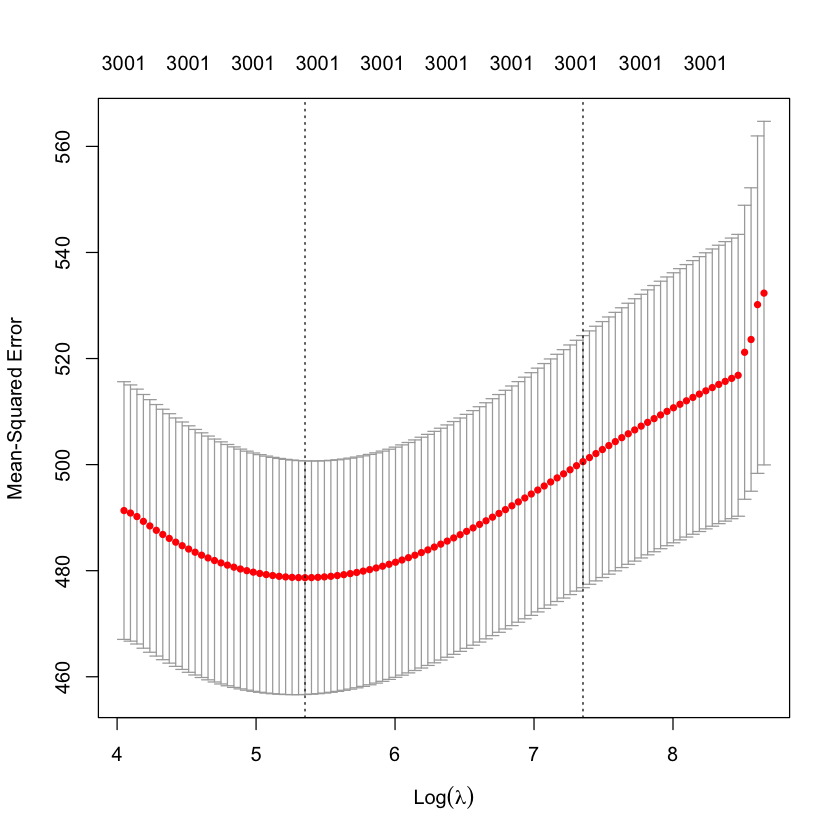

In [5]:
#Same process using Ridge regularization
set.seed(12)

#cross-validation ridge on training set
cv.ridge <- cv.glmnet(data.train.x.matrix, data.train.y, alpha = 0)
plot(cv.ridge)
best.ridge <- glmnet(data.train.x.matrix, data.train.y, alpha = 0, lambda = cv.ridge$lambda.min)
coeffs<-coef(best.ridge)

#use model on training data set ti make predictions
y<-predict(best.ridge,data.train.x.matrix)
RMSE.train=sqrt(mean((y-data.train.y)**2))
print(paste0("RMSE for training set: ",RMSE.train))

#test ridge regularization on test set
y<-predict(best.ridge, data.test.x.matrix)
RMSE.test=sqrt(mean((y-data.test.y)**2))
print(paste0("RMSE for test set: ",RMSE.test))

We try to do a submission with ridge regularization by using the whole training set to have a more accurate model :

In [11]:
data.x <- data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))]
data.x.matrix <- as.matrix((model.matrix(~.-1, data.x)))
data.y <- data$VALENCE.PLEASANTNESS
best.ridge_ <- glmnet(data.x.matrix, data.y, alpha = 0, lambda = cv.ridge$lambda.min)

In [14]:
data_training <- read.csv(file.path("..", "data", "training_data.csv"))
data_training$Intensity<-as.numeric(as.factor(data_training$Intensity))
data_training <- data_training[,-which(names(data_training) %in% c("VALENCE.PLEASANTNESS"))]
data_training <-data_training[,-which(names(data_training) %in% c("SWEETORSOUR"))]

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]
data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,( which(apply(data_training, 2, var) != 0))]#remove the same predictors   
data_test_matrix <- as.matrix((model.matrix(~.-1, data_test)))
pred_test <- predict(best.ridge_,data_test_matrix)
#pred_test
data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
data_sub
write.csv(data_sub,file="Sub4.csv", row.names = FALSE)

Id,VALENCE.PLEASANTNESS
1,35.71853
2,51.78616
3,42.11349
4,49.55248
5,37.09892
6,54.67266
7,31.70123
8,55.31707
9,40.35612
10,50.42527


Since we observed in the exploration part that some predictors seemed to be highly correlated, we will now try using the bootstrap to see if we can optimize our fit.

In [18]:
###Define the model

bootstrap<-function(data) data[sample(nrow(data),nrow(data),replace=T),]

fitted.coefficients.ridge <- function(data){
    #prepare data
    datax<-as.matrix(data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))])
    datay<-data$VALENCE.PLEASANTNESS

    cv.ridge <- cv.glmnet(datax, datay, alpha = 0)
    best.ridge <- glmnet(datax, datay, alpha = 0, lambda = cv.ridge$lambda.min)#choose the best lambda
    
    return(as.matrix(coef(best.ridge)))
}

#adds a column of 1 for the intercept
bias_input <- function(X) cbind(rep(1, ifelse(is.null(nrow(X)), length(X), nrow(X))), X)

#number of bootstrap dataset
B=6

#if you want to check the number of bootstrap needed and see the RMSE at each step
summary_bootstrap_withplot<-function(B, data.boot){
    coeffs=c()
    #prepare data
    data.train.prep<-bias_input(data.train.x.matrix)
    #find coefficients with ridge
    coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
    #predict result
    y.pred<-data.train.prep%*%rowMeans(coeffs)
    #compute RMSE
    RMSE_bootstrap<-sqrt(mean((y.pred-data.train.y)**2))
    plot(1,RMSE_bootstrap,xlim=c(1,B))
    for (i in 2:B){
       coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
       y.pred<-data.train.prep%*%rowMeans(coeffs)
       RMSE_bootstrap<-sqrt(mean((y.pred-data.train.y)**2))
       points(i,RMSE_bootstrap)
    }
    return (rowMeans(coeffs))
}

#this method is useful to compute the coefficient without monitoring of the RMSE
summary_bootstrap<-function(B,data.boot){
    coeffs=c()
    for (i in 2:B){
       coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
    }
    return (rowMeans(coeffs))
}
beta<-summary_bootstrap(B,data.train)



#####Use the model to make predictions



#preparation of train set to fit output form
data.train.prep<-bias_input(data.train.x.matrix) #add column of 1 for the intercept

#compute train error
y.pred<-data.train.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.pred-data.train.y)**2))
print(paste0("RMSE on the training data with bootstrap: ",RMSE_bootstrap.train))

#compute test error
data.test.prep<-bias_input(data.test.x.matrix) #add column of 1 for the intercept
y.test.pred<-data.test.prep%*%beta
RMSE_bootstrap.test<-sqrt(mean((y.test.pred-data.test.y)**2))
print(paste0("RMSE on the test data with ridge regularization and bootstrap: ",RMSE_bootstrap.test))


[1] "RMSE on the training data with bootstrap: 18.1079186678875"
[1] "RMSE on the test data with ridge regularization and bootstrap: 23.0389744566162"


In the end this approach gives slightly better results, depending on the run, on the training data but generally not significantly better on the test set, the data visibly doesn't show heteroscedastic behaviour (error depending on parameters). We can thus stick with ridge or lasso regularization.